# Minimal PyTorch RNN

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/Udacity_DLWPT/recurrent-neural-networks/char-rnn/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


# Dataloader

Create a custom dataset and dataloader

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
class TextSet(Dataset):
    def __init__(self, txt_file_path, seq_length=64, start=0, stop=None, device='cpu'):
        self.seq_length = seq_length
        # Read in text
        with open(txt_file_path, 'r') as f:
            text = f.read()
        if stop is None:
            self.text = text[start:]
        else:
            self.text = text[start:stop]
        # Encode
        self.chars = tuple(set(text))
        self.n_chars = len(self.chars)
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {char: i for i, char in self.int2char.items()}
        self.encoded_text = np.array([self.char2int[char] for char in self.text])

    def __len__(self):
        # Return total number of whole independent sequences minus one.
        # Minus one because we don't wrap data around, for simplicity
        sequences = len(self.encoded_text) // self.seq_length - 1
        return int(sequences)

    def __getitem__(self, idx):
        # Target is next character
        begin = self.seq_length * idx
        end = begin + self.seq_length
        data = self.encoded_text[begin:end]
        target = self.encoded_text[begin + 1:end + 1]
        # One-hot-encode the data. 
        data_one_hot = np.zeros((self.seq_length, self.n_chars), dtype=np.float32)
        data_one_hot[np.arange(self.seq_length), data] = 1.
        return torch.from_numpy(data_one_hot).to(device), torch.from_numpy(target).to(device)

In [5]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Model Setup

In [6]:
class CharRNN(nn.Module):

    """
    GG: Would like to understand how n_hidden and n_layers are chosen.  n_hidden is
    O(sentence size), maybe? Not covered in Udacity.

    - tokens is the set of all possible characters
    """
    
    def __init__(self, file_path, n_hidden=1024, n_layers=2,
                               drop_prob=0.2):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        # creating character dictionaries, as before
        with open(file_path, 'r') as f:
            tokens = tuple(set(f.read()))
        self.chars = tokens
        self.n_chars = len(self.chars)
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the layers of the model
        # We are one-hot encoding, so the inputs are of length of the vocab
        self.RNN = nn.RNN(len(self.chars),
                          self.n_hidden, 
                          self.n_layers, 
                          batch_first=True, 
                          dropout=self.drop_prob)
        # nn.RNN dropout is only applied *between* layers, so add another.
        self.dropout = nn.Dropout(self.drop_prob)
        # GG: Use CrossEntropyLoss so that we only output raw scores
        self.fc1 = nn.Linear(self.n_hidden, len(self.chars))
    
    def forward(self, x, hidden):
        """Forward pass through the network. 
        These inputs are x, and the hidden/cell state `hidden`.
        """
                
        ## TODO: Get the outputs and the new hidden state from the RNN
        # Pass through RNN, dropout, and linear
        x, hidden = self.RNN(x, hidden)
        x = self.dropout(x)
        # Collapsing every element in each batch to a single dimension
        x = x.contiguous().view(-1, self.n_hidden)
        x = self.fc1(x)
        # Output x is of shape x.shape = (batch_size * seq_length, self.chars)
        # giving batch_size * seq_length predictions for the next character which can be checked
        
        return x, hidden
    
    
    def init_hidden(self, batch_size):
        """Initializes hidden state.
        """
        # Create one new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of RNN
        # GG: This just gives us an instance of the Parameter class, which we can 
        # easily overwrite as below
        weight = next(self.parameters())
        # Initialize to zero and move to appropriate device
        hidden = weight.new_zeros(self.n_layers, batch_size, self.n_hidden)
        # GG: A little confused why we need this, since if we just don't pass in any
        # hidden state at all, it defaults to a zero tensor, no? This this just
        # makes later code cleaner.
        return hidden 

Testing

In [7]:
# Helper for printing samples
def input_to_text(tensor, net):
    seq_length = tensor.shape[0]
    # GG: Clean up. Nested comprehension is nearly always a bad idea.
    text = ''.join([net.int2char[int(sum(idx * num for idx, num in enumerate(tensor[row,:])).item())] for row in range(seq_length)])
    return text

def target_to_text(tensor, net):
    seq_length = tensor.shape[0]
    text = ''.join([net.int2char[item.item()] for item in tensor])
    return text

In [8]:
# File info
file_name = 'websters'
file_path = FOLDERNAME + 'data/' + f'{file_name}' + '.txt'
with open(file_path, 'r') as f:
            text_len = len(f.read())
# Train/Val split.
val_frac = .1
val_idx = int((1 - val_frac) * text_len)
seq_length = 128
train_set = TextSet(file_path, seq_length=seq_length, stop=val_idx, device=device)
val_set = TextSet(file_path, seq_length=seq_length, start=val_idx, device=device)
# Batch properties
batch_size = 128
train_loader = DataLoader(train_set,
                          batch_size=batch_size, 
                          shuffle=True,
                          drop_last=True)
val_loader = DataLoader(val_set, 
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

Some messy testing code:

In [9]:
RNN_test = CharRNN(file_path)
RNN_test.to(device)
print(RNN_test.char2int)
hidden_test = RNN_test.init_hidden(batch_size=batch_size)
print('hidden shape', hidden_test.shape)
batches = iter(val_loader)
x_test, y_test = next(batches)
out_test, _ = RNN_test(x_test, hidden_test)
print('data shape', x_test.shape)
print('target shape', y_test.shape)
print('output shape:', out_test.shape)
print('loss:', F.cross_entropy(out_test, y_test.view(-1)))
#RNN_test(, hidden_0)
# The parameters are the weights and biases, not the hidden layer data
for param in RNN_test.named_parameters():
    print('param:', param[0], 'shape:', param[1].shape)

# Some sample text, as a sanity check
for example in range(2):
    sample = x_test[example]
    target = y_test[example]
    print(f'Sample {example + 1}\n',
          input_to_text(sample, RNN_test), 
          target_to_text(target, RNN_test),
          '\n',
          sep='\n')

{'!': 0, 'N': 1, 'ç': 2, 's': 3, 'I': 4, 'ë': 5, ';': 6, 'ì': 7, '&': 8, '\t': 9, '¼': 10, 'G': 11, 'Þ': 12, 'x': 13, "'": 14, '%': 15, 'E': 16, 'v': 17, '^': 18, 'r': 19, '\\': 20, 'D': 21, 'S': 22, 'ý': 23, '~': 24, 'P': 25, '<': 26, '§': 27, 'ï': 28, 'H': 29, '÷': 30, 'a': 31, ')': 32, '\n': 33, '(': 34, 'Æ': 35, 'ö': 36, '2': 37, '6': 38, 'ù': 39, 'ä': 40, 'b': 41, '¾': 42, '|': 43, 'o': 44, 'g': 45, 'w': 46, 'J': 47, '"': 48, 'z': 49, 't': 50, 'i': 51, 'k': 52, 'è': 53, 'þ': 54, '=': 55, 'ú': 56, '1': 57, 'Ç': 58, 'A': 59, 'F': 60, 'à': 61, '£': 62, '4': 63, '{': 64, 'Q': 65, '-': 66, '`': 67, 'û': 68, 'u': 69, 'j': 70, 'p': 71, 'ð': 72, '½': 73, 'O': 74, 'l': 75, '\ufeff': 76, '$': 77, 'K': 78, 'í': 79, 'm': 80, 'R': 81, '/': 82, 'B': 83, ']': 84, 'Ü': 85, '+': 86, 'á': 87, 'ñ': 88, '¿': 89, '*': 90, 'q': 91, ',': 92, 'ã': 93, '@': 94, 'c': 95, 'U': 96, '7': 97, '#': 98, '×': 99, '>': 100, 'ü': 101, 'ó': 102, 'é': 103, '3': 104, 'ò': 105, 'X': 106, 'd': 107, '[': 108, 'º': 109, '

## Time to train

The train function gives us the ability to set the number of epochs, the learning rate, and other parameters.

Below we're using an Adam optimizer and cross entropy loss since we are looking at character class scores as output. We calculate the loss and perform backpropagation, as usual!

A couple of details about training: 
>* Within the batch loop, we detach the hidden state from its history; this time setting it equal to a new *tuple* variable because an RNN has a hidden state that is a tuple of the hidden and cell states.
* We use [`clip_grad_norm_`](https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html) to help prevent exploding gradients.

In [10]:
def train(architecture,
          file_path,
          n_hidden=512,
          n_layers=2,
          n_epochs=10,
          batch_size=128, 
          seq_length=128, 
          lr=1e-2,
          clip=5,
          val_frac=0.1,
          print_every=100,
          drop_prob=.5,
          device='cpu'):
    """Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    """
    net = architecture(file_path, 
                       n_hidden=n_hidden, 
                       n_layers=n_layers, 
                       drop_prob=drop_prob)
    net.to(device)
    net.train()
    # total number of trainable parameters
    total_trainable_params = sum(item.numel() for item in net.parameters() if item.requires_grad)
    # The number of trainable parameters should be similar to text length (apparently)
    with open(file_path, 'r') as f:
            text_len = len(f.read())
    print(f'Trainable Parameters: {total_trainable_params:.2E}',
          'Text length:', f'{text_len:.3E}')
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Setting up dataloaders
    with open(file_path, 'r') as f:
                text_len = len(f.read())
    # Train/Val split.
    val_idx = int((1 - val_frac) * text_len)
    train_set = TextSet(file_path,
                        seq_length=seq_length, 
                        stop=val_idx, 
                        device=device)
    val_set = TextSet(file_path,
                      seq_length=seq_length,
                      start=val_idx, 
                      device=device)
    print(f'Training set size: {len(train_set):.2E}',
          f'Validation set size: {len(val_set):.2E}',
          sep='\n')

    train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)
    val_loader = DataLoader(val_set, 
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=True)
    
    # Training.
    net.to(device)
    n_chars = net.n_chars
    training_history, validation_history = [], []

    for e in range(n_epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        for idx, (inputs, targets) in enumerate(train_loader):
            # Progress counter
            progress_points = [int(len(train_set) * step / 10) for step in range(1, 10)]
            if idx in progress_points:
                print(f'Epoch {e} {int(idx / len(train_set) * 100)} percent complete')

            # Truncated backprop through time. Coded so that it will work for
            # any of {RNN, LSTM, GRU}
            h = h.detach()
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(-1))
            loss.backward()
            training_history.append(loss.item())
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / RNNs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
        # loss stats at end of each epoch
        else:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, targets in val_loader:
                val_h = val_h.detach()
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, targets.view(-1))
                val_losses.append(val_loss.item())
                validation_history.append(val_loss.item())
            
            net.train() # reset to train mode after iterationg through validation data
            print(f"Epoch: {e + 1}/{n_epochs}...",
                  f"Loss: {loss.item():.4f}...",
                  f"Val Loss: {np.mean(val_losses):.4f}")
        
    # Training ended
    else:
        # Plot training loss history
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.plot(training_history, label='Training Losses')
        ax1.legend()
        ax2.plot(validation_history, label='Validation Losses')
        ax2.legend()
        plt.show()

        return net

## Instantiating the model

Now we can actually train the network. First we'll create the network itself, with some given hyperparameters. Then, define the mini-batches sizes, and start training!

In [24]:
# Copy the file locally from Drive for speed reasons
file_name = 'websters'
drive_file_path = FOLDERNAME + 'data/' + f'{file_name}' + '.txt'
!cp '{drive_file_path}' . 
!ls
file_path = 'websters.txt'

anna.txt  drive  sample_data  websters.txt


Trainable Parameters: 8.56E+04 Text length: 2.796E+07
Training set size: 1.97E+05
Validation set size: 2.18E+04
Epoch: 1/512... Loss: 2.6039... Val Loss: 2.5880
Epoch: 2/512... Loss: 2.3236... Val Loss: 2.2935
Epoch: 3/512... Loss: 2.1546... Val Loss: 2.1219
Epoch: 4/512... Loss: 2.0621... Val Loss: 2.0340
Epoch: 5/512... Loss: 2.0045... Val Loss: 1.9678
Epoch: 6/512... Loss: 1.9639... Val Loss: 1.9200
Epoch: 7/512... Loss: 1.9377... Val Loss: 1.8838
Epoch: 8/512... Loss: 1.8904... Val Loss: 1.8521
Epoch: 9/512... Loss: 1.8716... Val Loss: 1.8288
Epoch: 10/512... Loss: 1.8495... Val Loss: 1.8214
Epoch: 11/512... Loss: 1.8389... Val Loss: 1.7984
Epoch: 12/512... Loss: 1.8106... Val Loss: 1.7880
Epoch: 13/512... Loss: 1.8046... Val Loss: 1.7759
Epoch: 14/512... Loss: 1.8088... Val Loss: 1.7669
Epoch: 15/512... Loss: 1.7933... Val Loss: 1.7608
Epoch: 16/512... Loss: 1.7857... Val Loss: 1.7547
Epoch: 17/512... Loss: 1.7925... Val Loss: 1.7480
Epoch: 18/512... Loss: 1.7813... Val Loss: 1.74

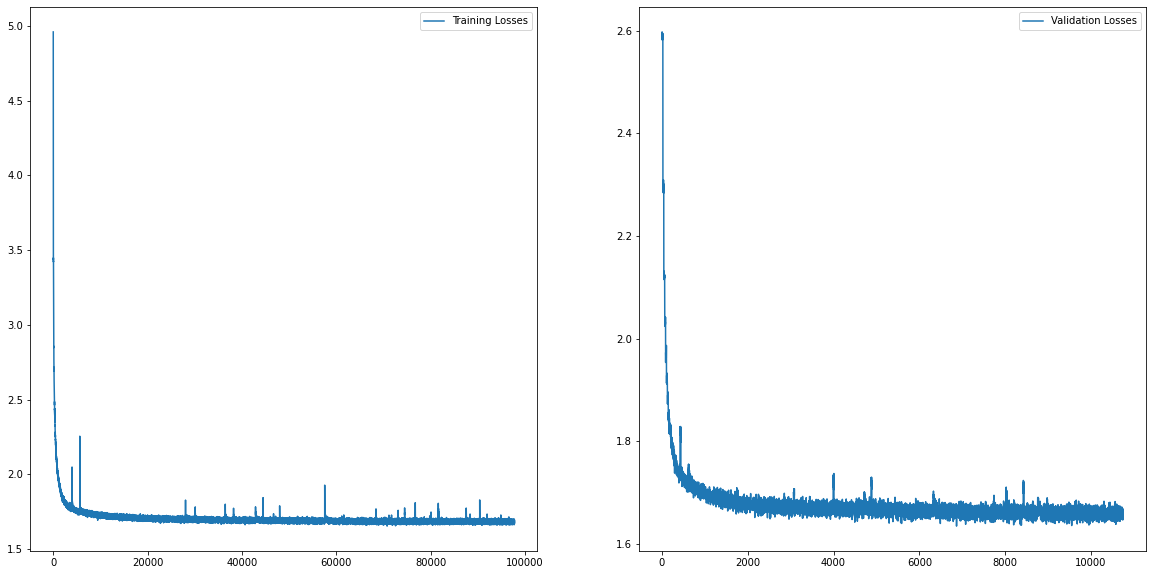

Training_time: 11384.543740051


In [25]:
# train the model
model_params = {'n_hidden': 128,
                'n_layers': 2,
                'batch_size': 1024,
                'seq_length': 128,
                'n_epochs': 512,
                'lr': .003,
                'device': device,
                'drop_prob': .1,
                'clip': 5
}
start = time.perf_counter()
trained_model = train(CharRNN,
                      file_path,
                      **model_params)
training_time = time.perf_counter() - start
print('Training_time:', training_time)

In [26]:
def one_hot_encode(arr, n_chars):
    # Initialize the encoded array
    one_hot = np.zeros((arr.size, n_chars), dtype=np.float32)
    # Fill the appropriate elements with ones via NumPy syntax
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_chars))
    
    return one_hot

In [27]:
def predict(net, char, h=None, top_k=None):
        """Given a character, predict the next character.
        Returns the predicted character and the hidden state.
        """
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        inputs = inputs.to(device)
        
        # detach hidden state from history
        # GG: Just for speed? Following Udacity here. Not like we are backpropagating.
        h = h.detach()
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).detach().to(device)
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            p, top_ch = p.to('cpu'), top_ch.to('cpu')
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

### Priming and generating text 

Typically you'll want to prime the network so you can build up a hidden state. Otherwise the network will start out generating characters at random. In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

In [28]:
def sample(net, size, prime='The', top_k=None):
    net.to(device)
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [29]:
print(sample(trained_model, 1000, prime='The', top_k=5))

Thell betining intrest sole on the acteacher, and stone of the princh, is sort. [R.] "The flats on the substance, or and proportude; a pelleated by stor are of was a perform three to
sender of a chuss way in the pore.

2. (Bot.) See Supposed to the particular sorged in a pains at a body and sunder in country foor to be a strengh in the classed to the charge of
an ease; crees or through the pecumitation, and substable as an expressing in the coulse.

PONTHONE
Pal"ment, n.

Defn: A polided of a limitatinn in an anches in compouding from which an induted in to state of sometimes of chubble in the couscer, or common a book. Spenser.

CHALESS
Si"le, v. i. [imp. & p. p.

Defn: Anything some part of color; contract to the colulity in company; to rish carry so propering a capabil of an act and
almost, a concoun antilers; the fool and the commonticul, as insects, when
the cancel the supplied out. The pation at the
person whom the state of
the pass or transtrine a cans of a conceis or clothed or